## Random Forest

Loading data...
Dataset shape: (20011, 31)

Target variable distribution:
y_active
0    14230
1     5781
Name: count, dtype: int64
Class balance: y_active
0    0.711109
1    0.288891
Name: proportion, dtype: float64

Dropping ID columns: ['userId']

Numeric features: 28
Categorical features: 1

Training set size: (14007, 29)
Test set size:     (6004, 29)

Running RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters: {'rf__max_depth': None, 'rf__max_features': 0.6, 'rf__max_samples': np.float64(0.7835558684167139), 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 17, 'rf__n_estimators': 134}
Best CV ROC-AUC: 0.9300

Refitting best model with n_estimators=500 for stability...

MODEL PERFORMANCE METRICS

Accuracy: 0.8546

Classification Report:
              precision    recall  f1-score   support

           0     0.9863    0.8067    0.8875      4269
           1     0.6716    0.9723    0.7944      1735

    accuracy                     

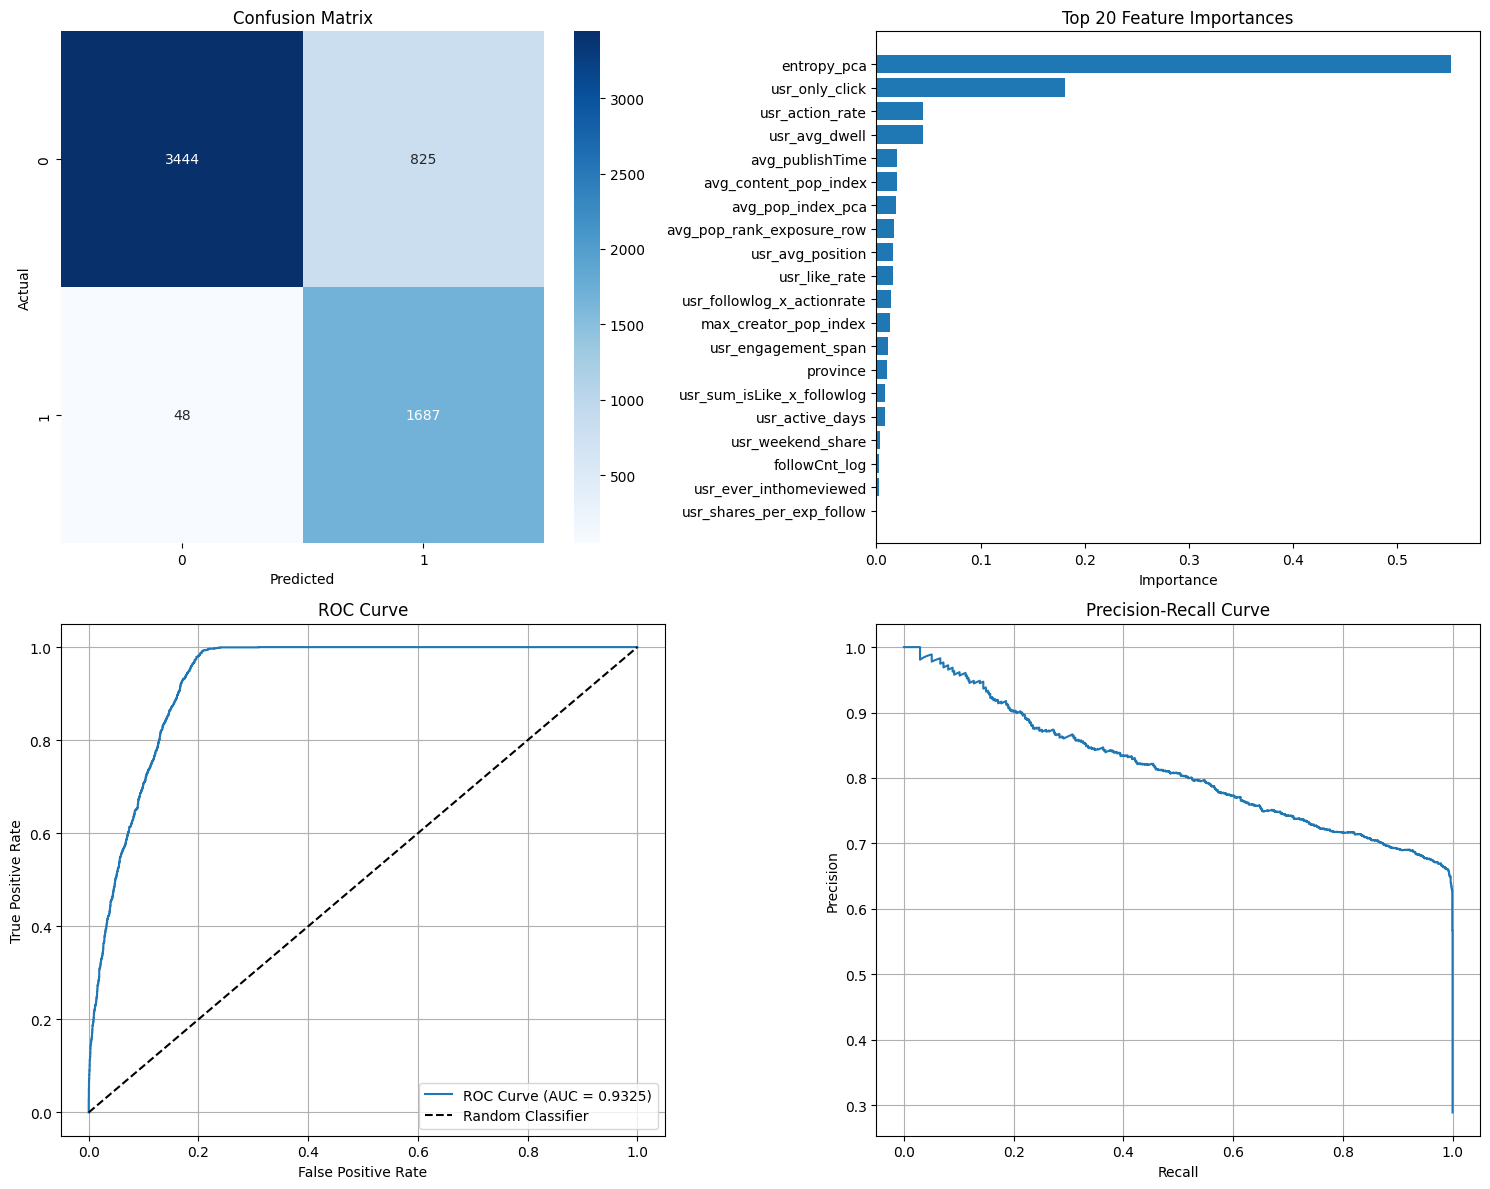

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, f1_score, accuracy_score
)
from joblib import Memory
from scipy.stats import randint, uniform

# Data Loading
print("Loading data...")
df = pd.read_csv("../data/user_level_data.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nTarget variable distribution:\n{df['y_active'].value_counts()}")
print(f"Class balance: {df['y_active'].value_counts(normalize=True)}")

# Feature and Target Separation
target = "y_active"
id_columns = ["mlogId", "userId", "creatorId"]
columns_to_drop = [target] + [c for c in id_columns if c in df.columns]
print(f"\nDropping ID columns: {[c for c in id_columns if c in df.columns]}")

X_raw = df.drop(columns=columns_to_drop, errors="ignore")
y = df[target].astype(int)

# Identify column types (let the pipeline handle encoding/imputation)
num_cols = selector(dtype_include=np.number)(X_raw)
cat_cols = [c for c in X_raw.columns if c not in num_cols]

print(f"\nNumeric features: {len(num_cols)}")
print(f"Categorical features: {len(cat_cols)}")

# Preprocessing Pipelines
numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocess = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols)
])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)
print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size:     {X_test.shape}")

# Model Pipeline with Caching
cache = Memory(location="cache_rf", verbose=0)
rf = RandomForestClassifier(
    n_jobs=-1,
    bootstrap=True,            # required for max_samples
    class_weight="balanced",   # helpful if imbalanced
    random_state=42
)
pipe = Pipeline([("prep", preprocess), ("rf", rf)], memory=cache)

#Hyperparameter Tuning with RandomizedSearchCV
# Narrow, high-impact ranges; subsample rows per tree to cut time
param_dist = {
    "rf__n_estimators": randint(120, 260),     # search smaller range first
    "rf__max_depth": [None, 10, 16, 24],
    "rf__min_samples_split": randint(2, 21),
    "rf__min_samples_leaf": randint(1, 11),
    "rf__max_features": ["sqrt", 0.4, 0.6],    # mix categorical + fractional
    "rf__max_samples": uniform(0.6, 0.3)       # 0.6–0.9 subsampling per tree
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=20,                  # speed knob: 10–30
    cv=3,                       # speed knob: 3 is a good default
    scoring="roc_auc",          # 'average_precision' for strong imbalance
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=False
)

print("\nRunning RandomizedSearchCV...")
search.fit(X_train, y_train)

print("\nBest Parameters:", search.best_params_)
print("Best CV ROC-AUC:", f"{search.best_score_:.4f}")

# Optional: refit best model with more trees for stability
best_model = search.best_estimator_
best_model.set_params(rf__n_estimators=500)
print("\nRefitting best model with n_estimators=500 for stability...")
best_model.fit(X_train, y_train)

# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Model Evaluation
print("\n" + "="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

try:
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")
except Exception:
    print("\nROC-AUC Score: Not available")

f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 Score (weighted): {f1:.4f}")

# Feature Importance Extraction
# With OrdinalEncoder, #features == len(num_cols) + len(cat_cols) → names map 1:1
rf_final = best_model.named_steps["rf"]
feature_names = list(num_cols) + list(cat_cols)
feature_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_final.feature_importances_
}).sort_values("importance", ascending=False)

print("\n" + "="*60)
print("TOP 20 FEATURE IMPORTANCES (impurity-based)")
print("="*60)
print("\n", feature_importance.head(20))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')

# 2. Feature Importance (Top 20)
top_features = feature_importance.head(20)
axes[0, 1].barh(top_features['feature'], top_features['importance'])
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title('Top 20 Feature Importances')
axes[0, 1].invert_yaxis()

# 3. ROC Curve
try:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[1, 0].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].set_title('ROC Curve')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
except Exception:
    axes[1, 0].text(0.5, 0.5, 'ROC Curve not available', ha='center', va='center')

# 4. Precision-Recall Curve
try:
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    axes[1, 1].plot(recall, precision)
    axes[1, 1].set_xlabel('Recall')
    axes[1, 1].set_ylabel('Precision')
    axes[1, 1].set_title('Precision-Recall Curve')
    axes[1, 1].grid(True)
except Exception:
    axes[1, 1].text(0.5, 0.5, 'Precision-Recall Curve not available', ha='center', va='center')

plt.tight_layout()
plt.show()


### Evaluation
Best Parameters: {'rf__max_depth': 24, 'rf__max_features': 0.6, 'rf__max_samples': 0.8550115733369398, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 167}
